In [1]:
import torch
from torch import nn
import selfies as sf
# Print torch version
print(torch.__version__)

2.3.0.post301


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
device

device(type='cuda')

In [3]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
# read in all the smiles
smiles_sf = open('data/1to6.dmu.selfies', 'r').read().splitlines()
print(len(smiles_sf))
print(max(len(w) for w in smiles_sf))
print(smiles_sf[-8:])

35466
120
['[N][C][C][C][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[N][C][C][N][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[O][C][C][C][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[O][C][C][N][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][C][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][N][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[N][C][N][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][C][Ring1][Ring1][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]']


In [4]:
# build the vocabulary of selfies tokens and mappings to/from integers
alphabet = sf.get_alphabet_from_selfies(smiles_sf)
#chars = sorted(list(set(''.join(smiles))))
stoi = {s:i+1 for i,s in enumerate(alphabet)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
VOCAB_SIZE = len(itos)
print(itos)
print(VOCAB_SIZE)

{1: '[N]', 2: '[#C]', 3: '[Ring1]', 4: '[O]', 5: '[C]', 6: '[#N]', 7: '[=O]', 8: '[=Ring1]', 9: '[Branch1]', 10: '[=Branch1]', 11: '[Ring2]', 12: '[=C]', 13: '[=N]', 0: '.'}
14


In [5]:
# shuffle the smiles
import random
random.seed(42)
random.shuffle(smiles_sf)

In [5]:
SEQ_LEN = 128
EMB_DIM = 20
LAT_DIM = 10

# build the dataset
def build_dataset(smiles_sf):
    X = []
    for s in smiles_sf:
        x = []
        for vocab in list(sf.split_selfies(s)) + ['.']:
            ix = stoi[vocab]
            x.append(ix)
        while len(x) < SEQ_LEN:
            x.append(0)
        X.append(x)
    X = torch.tensor(X)
    print(X.shape)
    return X
n1 = int(0.8 * len(smiles_sf))
n2 = int(0.9 * len(smiles_sf))
Xtr = build_dataset(smiles_sf[:n1])
Xdev = build_dataset(smiles_sf[n1:n2])
Xte = build_dataset(smiles_sf[n2:])

torch.Size([28372, 128])
torch.Size([3547, 128])
torch.Size([3547, 128])


In [6]:
for x in Xtr[-20:]:
    print(''.join(itos[ix.item()] for ix in x), '-->', x.tolist())

[C][=C][C][O][C][N][Ring1][Branch1][Ring1][Ring2]...................................................................................................................... --> [5, 12, 5, 4, 5, 1, 3, 9, 3, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[C][=C][C][O][N][N][Ring1][Branch1][Ring1][Ring2]...................................................................................................................... --> [5, 12, 5, 4, 1, 1, 3, 9, 3, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Create Variational Autoencoder model
class VAE_selfies_base(nn.Module):
    def __init__(self, seq_len = SEQ_LEN, vocab_size=VOCAB_SIZE, emb_dim = EMB_DIM, hidden_dim=100, latent_dim=LAT_DIM):
        super().__init__()
    
        # ecoder    
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)  
        self.rnn_emb2hid = nn.GRU(emb_dim, hidden_dim, batch_first=True)   
        self.fc_hid2mean = nn.Linear(hidden_dim, latent_dim)   
        self.fc_hid2logvar = nn.Linear(hidden_dim, latent_dim)  
        
        # decoder
        self.fc_lat2hid = nn.Linear(latent_dim, hidden_dim)  
        self.rnn_hid2emb = nn.GRU(emb_dim, hidden_dim, batch_first=True)  
        self.fc_emb2out = nn.Linear(hidden_dim, vocab_size)   
    
    def encode(self, x):
        x = self.emb(x)   # (B,20,20)
        _, hn_e = self.rnn_emb2hid(x)  # (1, B, 200) 
        hn_e = hn_e.squeeze(0)  # (B, 200)
        mean = self.fc_hid2mean(hn_e)  #   (B,10)
        logvar = self.fc_hid2logvar(hn_e)  #  (B,10)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar)
        z = mean + logvar * epsilon
        return z
    
    def decode(self, z):  # (B, 10)
        hn_d = self.fc_lat2hid(z) # (B, 200)
        hn_d = hn_d.unsqueeze(0)  # (1, B, 200)
        h0 = torch.zeros(z.size(0), SEQ_LEN, EMB_DIM).to(device)  # (B, 20, 20)
        z, _ = self.rnn_hid2emb(h0, hn_d) # (B, 20, 20) 
        x = self.fc_emb2out(z) # (B, 20, 13)
        return x
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar   

# Loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.cross_entropy(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD                

In [7]:
# Improved Variational Autoencoder model with GRU
class VAE_selfies(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, hidden_dim=100, latent_dim=LAT_DIM):
        super().__init__()

        # Encoder
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn_emb2hid = nn.GRU(emb_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2, bidirectional=True)
        self.fc_hid2mean = nn.Linear(hidden_dim * 2 * 2, latent_dim)  # Multiply by 2 due to bidirection, 2 again due to num_layers
        self.fc_hid2logvar = nn.Linear(hidden_dim * 2 * 2, latent_dim)
        
        # Decoder
        self.fc_lat2hid = nn.Linear(latent_dim, hidden_dim * 2)  # Adjusted for num_layers
        self.rnn_hid2emb = nn.GRU(emb_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2)
        self.fc_emb2out = nn.Linear(hidden_dim, vocab_size)
    
    def encode(self, x):
        x = self.emb(x)  # (batch_size, seq_len, emb_dim)
        _, hn_e = self.rnn_emb2hid(x)  # (num_layers * num_directions, batch, hidden_size)
        hn_e = hn_e.view(hn_e.size(1), -1)  # (batch, hidden_size * num_directions * num_layers) 
        mean = self.fc_hid2mean(hn_e) # (batch, latent_dim)
        logvar = self.fc_hid2logvar(hn_e) # (batch, latent_dim)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar)
        z = mean + torch.exp(0.5 * logvar) * epsilon  # Adjusted to ensure logvar is non-negative
        return z
    
    def decode(self, z):
        hn_d = self.fc_lat2hid(z)  # (batch, hidden_size * num_layers)
        hn_d = hn_d.view(2, z.size(0), -1)  
        h0 = torch.zeros(z.size(0), SEQ_LEN, EMB_DIM).to(device)
        z, _ = self.rnn_hid2emb(h0, hn_d)
        x_hat = self.fc_emb2out(z)
        return x_hat
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

# Improved Loss function with KLD annealing
def loss_function(x, x_hat, mean, log_var, beta=1.0):
    reproduction_loss = nn.functional.cross_entropy(x_hat, x, reduction='sum') / x.size(0)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0)
    return reproduction_loss + beta * KLD

In [8]:
# Create Variational Autoencoder with WaveNet architecture 
class VAE_selfies_WaveNet(nn.Module):
    def __init__(self, seq_len = SEQ_LEN, vocab_size=VOCAB_SIZE, emb_dim = EMB_DIM, hidden_dim=100, latent_dim=LAT_DIM):
        super().__init__()
    
        # ecoder    
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)  
        self.fc1 = nn.Linear(emb_dim * 2, hidden_dim, bias=False) 
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)   
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)        
        self.fc4 = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)
        self.fc6 = nn.Linear(hidden_dim * 4, hidden_dim, bias=False)    
        
    
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.bn5 = nn.BatchNorm1d(hidden_dim)
        self.bn6 = nn.BatchNorm1d(hidden_dim)
        
        self.dropout = nn.Dropout(0.2) 
        self.relu = nn.ReLU()
    
        self.fc_hid2mean = nn.Linear(hidden_dim, latent_dim)  
        self.fc_hid2logvar = nn.Linear(hidden_dim, latent_dim)  
        
        # decoder
        self.fc_lat2hid = nn.Linear(latent_dim, hidden_dim)  
        self.fc_hid2emb = nn.Linear(hidden_dim, seq_len * emb_dim)   
        self.fc_emb2out = nn.Linear(emb_dim, vocab_size)   
    
    def encode(self, x):
        x = self.emb(x)  
        x = x.view(x.shape[0] * x.shape[1] // 2, x.shape[2] * 2)   
        x = self.fc1(x)  
        x = self.bn1(x)
        x = self.dropout(x)
        x =self.relu(x)
        
        x = x.view(x.shape[0] // 2, x.shape[1] * 2)  
        x = self.fc2(x)  
        x = self.bn2(x)
        x =self.dropout(x)
        x =self.relu(x)
        
        x = x.view(x.shape[0] // 2, x.shape[1] * 2)   
        x = self.fc3(x)  
        x = self.bn3(x)
        x = self.dropout(x)
        x =self.relu(x)
        
        x = x.view(x.shape[0] // 2, x.shape[1] * 2)   
        x = self.fc4(x) 
        x = self.bn4(x)
        x =self.dropout(x)
        x =self.relu(x)
        
        x = x.view(x.shape[0] // 2, x.shape[1] * 2)   
        x = self.fc5(x) 
        x = self.bn5(x)
        x =self.dropout(x)
        x =self.relu(x)
        
        x = x.view(x.shape[0] // 4, x.shape[1] * 4)
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.dropout(x)
        x =self.relu(x)
        
        
        mean = self.fc_hid2mean(x)    
        logvar = self.fc_hid2logvar(x) 
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar)
        z = mean + torch.exp(0.5* logvar) * epsilon  
        return z
    
    def decode(self, z):
        z = self.fc_lat2hid(z)  
        z = self.relu(z)
        z = self.fc_hid2emb(z)  
        z = z.view(z.shape[0], z.shape[1] // EMB_DIM, EMB_DIM)
        x = self.fc_emb2out(z)  
        return x
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar   

# Loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.cross_entropy(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD                

In [21]:
batch_size = 64
Xb = torch.randint(0,VOCAB_SIZE,(batch_size,SEQ_LEN)).to(device)
print(Xb.shape)
model = VAE_selfies(seq_len=SEQ_LEN).to(device)
x, mean, logvar = model(Xb)
total_params = sum(p.numel() for p in model.parameters())
print(x.shape, total_params)

torch.Size([64, 128])
torch.Size([64, 128, 14]) 363514


In [10]:
#model = VAE_selfies().to(device)
model = VAE_selfies_WaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
epochs = 210000
batch_size = 64
lossi = []
for epoch in range(epochs):
    # Sample batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[idx].to(device)
    
    # Train the model
    model.train()
    optimizer.zero_grad()
    x_hat, mean, log_var = model(Xb)
    loss = loss_function(Xb.view(-1), x_hat.view(-1, VOCAB_SIZE), mean, log_var)
    lossi.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 10000 == 0:
        print("\tEpoch", epoch, "\tLoss: ", loss.item())
    
    modelName = 'VAE_selfies_WaveNet'
    if epoch % 50000 == 0 and epoch > 0:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'iteration': epoch
        }
        torch.save(checkpoint, f'models/{modelName}_checkpoint_{epoch}.pt')
        print(f'Checkpoint saved at iteration {epoch}')
    if epoch > 100000:
        lr = 1e-4
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


/home/hieu/miniconda3/envs/mlmat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


	Epoch 0 	Loss:  118.62039947509766
	Epoch 10000 	Loss:  0.13260848820209503
	Epoch 20000 	Loss:  0.14461089670658112
	Epoch 30000 	Loss:  0.14329594373703003
	Epoch 40000 	Loss:  0.1462191939353943
	Epoch 50000 	Loss:  0.1357833594083786
Checkpoint saved at iteration 50000
	Epoch 60000 	Loss:  0.1330537647008896
	Epoch 70000 	Loss:  0.13448269665241241
	Epoch 80000 	Loss:  0.1464383453130722
	Epoch 90000 	Loss:  0.13371218740940094
	Epoch 100000 	Loss:  0.1340254545211792
Checkpoint saved at iteration 100000
	Epoch 110000 	Loss:  0.13562600314617157
	Epoch 120000 	Loss:  0.13926556706428528
	Epoch 130000 	Loss:  0.13087128102779388
	Epoch 140000 	Loss:  0.13104724884033203
	Epoch 150000 	Loss:  0.13307273387908936
Checkpoint saved at iteration 150000
	Epoch 160000 	Loss:  0.13387586176395416
	Epoch 170000 	Loss:  0.13593950867652893
	Epoch 180000 	Loss:  0.13657952845096588
	Epoch 190000 	Loss:  0.13623535633087158
	Epoch 200000 	Loss:  0.13672959804534912
Checkpoint saved at iteratio

In [42]:
from rdkit import Chem
model = VAE_selfies(seq_len=120).to(device)
#model = VAE_selfies_WaveNet(seq_len=128).to(device)
checkpoint = torch.load('models/VAE_selfies_checkpoint_200000.pt')
#checkpoint = torch.load('models/VAE_selfies_WaveNet_checkpoint_200000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
latent_dim = LAT_DIM
def generate_selfies(z, temperature=1.0):
    z_sample = torch.tensor([z], dtype=torch.float).to(device)
    logits = model.decode(z_sample)
    logits = logits.view(-1, VOCAB_SIZE)
    
    # Apply temperature
    logits = logits / temperature
    
    prob = nn.functional.softmax(logits, dim=1)
    #indices = torch.argmax(prob, dim=-1)
    indices = torch.multinomial(prob, num_samples=1).squeeze(-1)
    #print(indices)
    return ''.join(itos[ix.item()] for ix in indices).replace('.','')
    #return indices
samp = torch.randn(latent_dim)
#samp = torch.tensor([0,0])
print(samp)
gen_selfies = generate_selfies(samp.tolist())
print(gen_selfies)
gen_smiles = sf.decoder(gen_selfies)
print(gen_smiles, Chem.MolToSmiles(Chem.MolFromSmiles(gen_smiles)))

tensor([ 0.2391, -2.1251,  1.0908, -0.5845,  0.0598, -1.0159, -0.4206, -2.1525,
         1.1636,  0.0404])
[=C][=C][C][=Ring1][=Branch1][Branch1][Ring2]
C=1=C=C=1 C1=C=C=1


In [44]:
# Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

uniqueList = []
validCount = 0
for i in range(10000):
    samp = torch.randn(LAT_DIM)
    smi_sf = generate_selfies(samp.tolist(), temperature=15.0)
    smi = sf.decoder(smi_sf)
    if Chem.MolFromSmiles(smi):
        validCount+=1
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        if canon_smi not in uniqueList:
            uniqueList.append(canon_smi)

print(f'Valid SMILES: {validCount}/10000')
print(f'Unique SMILES: {len(uniqueList)}/{validCount}')

Valid SMILES: 10000/10000
Unique SMILES: 3934/10000


In [45]:
print(uniqueList)

['C1=CN=1', 'C1=NCN=1', 'O=C1C=NNOCC1', '[nH]1oo1', 'N=CNC=C1C=C=N1', 'COOC#N', 'NN', 'N=NC=NN=C1C=NO1', 'C=NON=C=O', 'C#C', 'C=NONCCCOOC(=C)N=C', 'N=O', 'C=O', 'C#CCC=CC#CO', 'C1N=N1', 'N=CN=O', 'C1ON=NO1', 'C1c2nn1o2', 'C1=COON=1', 'N', 'CC#N', 'C#CNN=C', 'O=NO', 'N=C=O', 'C1=NC(=C=NN=NCNC2=NON=NC=C2)N=1', 'C=C=C1NOC(O)=C1C=O', 'CC=O', 'O', 'O=O', 'C#N', 'CC', 'C=NCOC=C=O', 'O=C1NNCN(N=c2cc3on2-3)C2(CO2)O1', 'N#CNO', 'N#CN', 'C1#CC1', 'CN=O', 'C1=NO1', 'C1#CO1', 'C=C=O', 'C=CN=CONON=C=O', 'C#CN=C=C=N', 'C#CO', 'N=CC#CN=O', 'C1#CNOC1', 'C=C=C=O', 'N=NC=C=COC=O', 'O=NNO', 'C1=NN=1', 'NC=O', 'ON(O)O', 'C', 'C1=C=NC=1', 'O=COC=O', 'C1=CNON=1', 'N1=C2NON1C1N=C1O2', 'N1=NO1', 'C=C=NN=CC', 'N#CN=CCON', 'NN=O', 'O=COOO', 'N#N', 'NC=CCN=O', 'N1=NNON=N1', 'NCN=O', 'C=C=N', 'CON1CC=N1', 'C1=NN=N1', 'N#CN=N', 'C=C=NC=O', 'O=CO', 'O=C=NC1C#CC1', 'C=NC=CCOO', 'NN1N=CON1', 'N=N', 'Cn1oo1', 'CON=C=N', 'NC=NOC=O', 'N=C1CC1=C=O', 'C#CN(C)OC#N', 'CNONC=O', 'N=CC1(N2c3con32)C=NONOO1', 'N=C=C=CCC=CN(C=O)

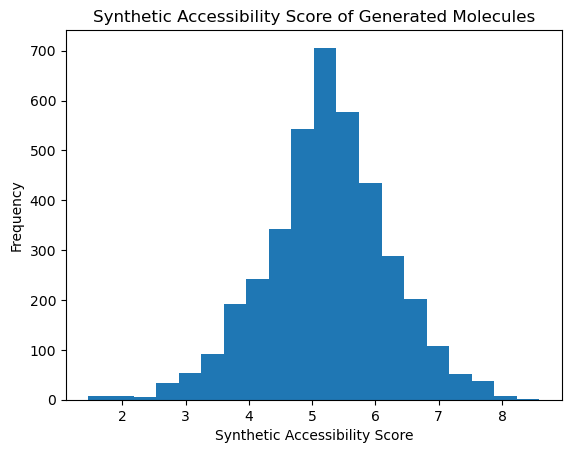

3934 3934


In [46]:
# Compute synthetic accessibility score 
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score.sascorer import calculateScore
sasList = [calculateScore(Chem.MolFromSmiles(s)) for s in uniqueList]
plt.hist(sasList, bins=20)
plt.xlabel('Synthetic Accessibility Score')
plt.ylabel('Frequency')
plt.title('Synthetic Accessibility Score of Generated Molecules')
plt.show()
print(len(sasList), len(uniqueList))

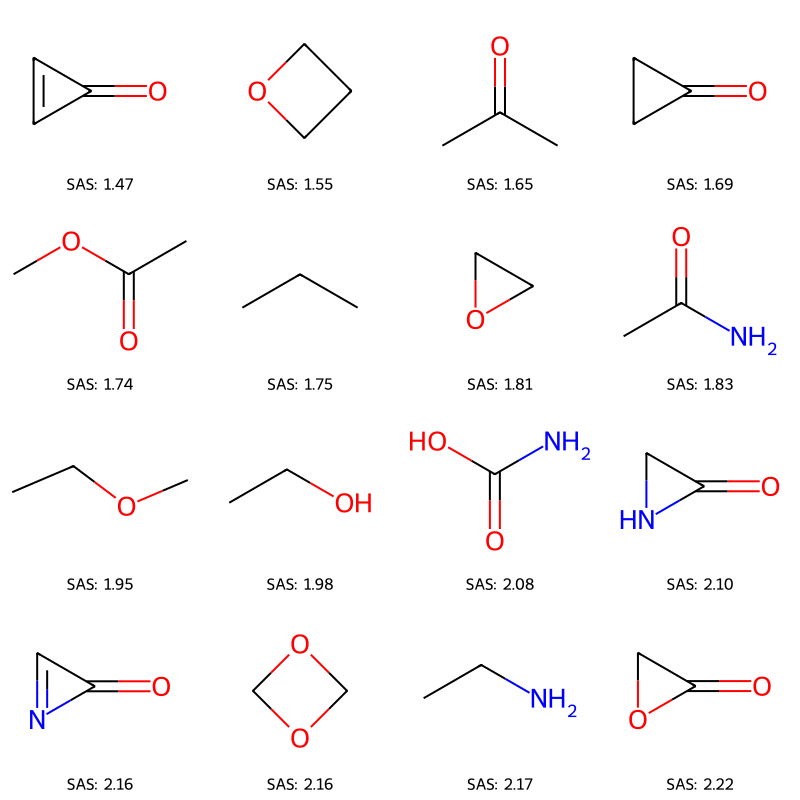

In [47]:
# Sort the generated molecules by synthetic accessibility score
from rdkit.Chem import Draw
sortedList = [s for _,s in sorted(zip(sasList,uniqueList), reverse=False)]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[:16]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[:16]])

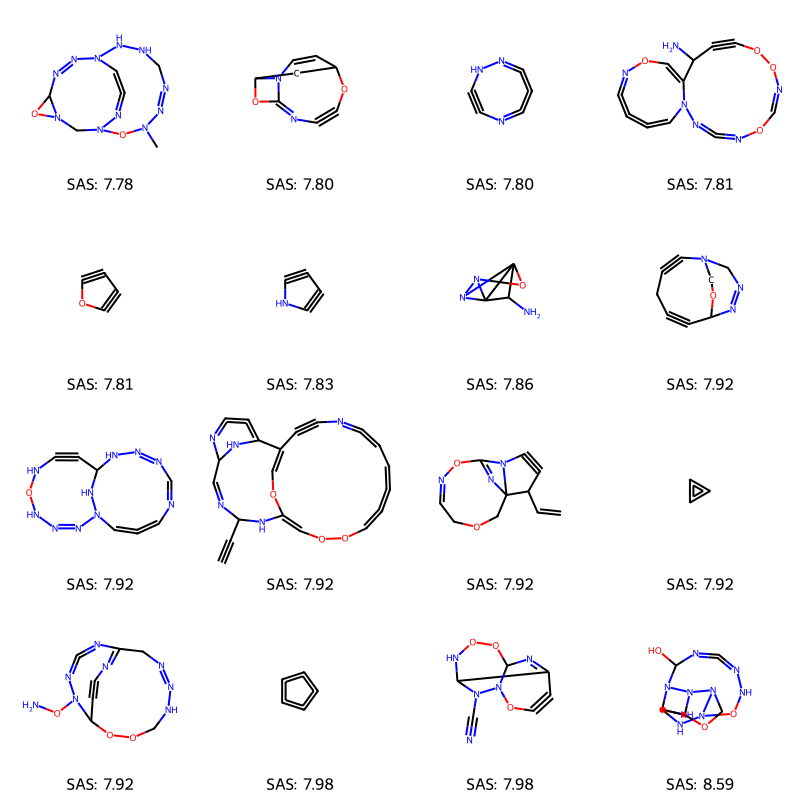

In [48]:
# Draw the molecules with the highest synthetic accessibility score
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[-16:]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[-16:]])